<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/Semantic_segmentation_dermoscopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation

## imports

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from matplotlib import rcParams
from skimage.io import imread
from skimage.transform import resize
from time import time
from torch.utils.data import DataLoader
from torchvision import models
from typing import Callable, List, Dict, Tuple

In [64]:
rcParams['figure.figsize'] = (15,4)

## Download and unzip dataset

In [65]:
%%capture
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [66]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [67]:
images = []
lesions = []

for root, dirs, files in os.walk(os.path.join('PH2Dataset', 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

## Set config

In [100]:
class CFG:
  batch_size = 32
  out_channels = 64
  batch_norm_momentum = 0.1
  seed = 42
  device = lambda: torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Freeze seeds

In [69]:
def seed_everything(seed: int=CFG.seed) -> None:
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

In [70]:
def seed_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for repeatability and reproducibility.

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        seed_everything()
        result = func(*args, **kwargs)
        return result
    return wrapped_function

In [71]:
seed_everything()

## Dataset

### Resize and transform

In [89]:
size = (256, 256)
X = np.array([resize(x, size, mode='constant', anti_aliasing=True,) for x in images], np.float32)
Y = np.array([resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions], np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


### Preview images

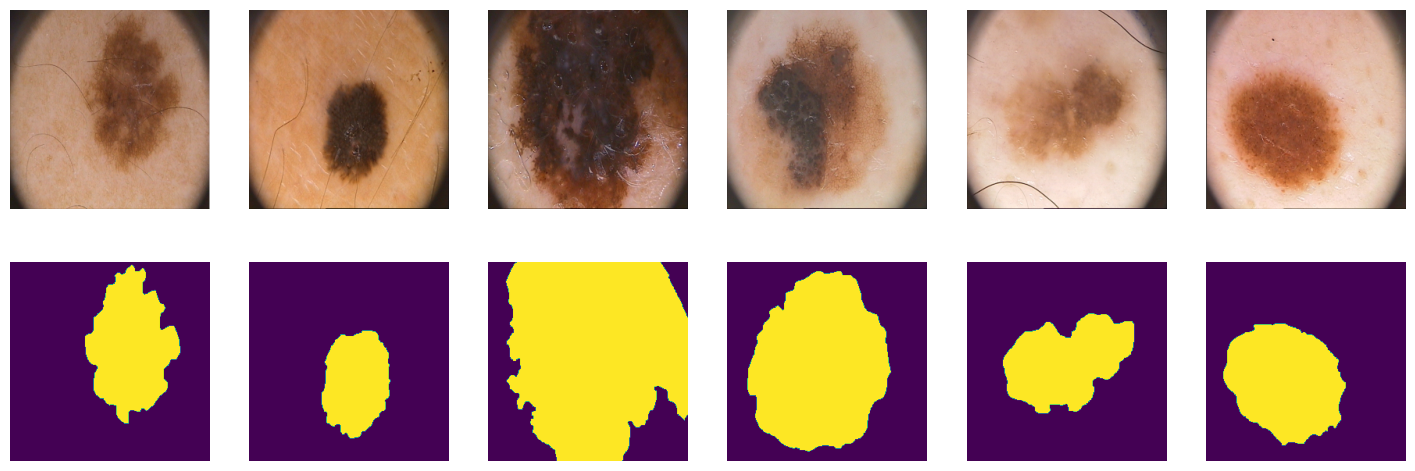

In [90]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Split indexes

In [75]:
@seed_wrapper
def tvt_split_custom(X):
  idx = np.random.choice(len(X), len(X), False)
  return np.split(idx, [100, 150])

In [91]:
train, val, test = tvt_split_custom(X)

### Create dataloaders

In [92]:
def match_idxs(idx: np.ndarray, xs: np.ndarray = X, ys: np.ndarray = Y) -> list:
    """
    Match indices and create a list of tuples.

    Parameters:
    - idx: np.ndarray
        An array of indices.
    - xs: np.ndarray, optional
        The input array for x (default value X).
    - ys: np.ndarray, optional
        The input array for y (default value Y).

    Returns:
    - list
        A list of tuples created by matching indices.
    """
    x = np.moveaxis(xs[idx], source=3, destination=1)
    y = ys[idx, np.newaxis]
    new_array = list(zip(x, y))
    return new_array

In [93]:
data_train = DataLoader(match_idxs(train), batch_size=CFG.batch_size, shuffle=True)
data_val = DataLoader(match_idxs(val), batch_size=CFG.batch_size, shuffle=True)
data_test = DataLoader(match_idxs(test), batch_size=CFG.batch_size, shuffle=False)


## SegNet

----------------------------------------------------------------------------------------

<img src="в=">

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [114]:
class SegNet(nn.Module):
    def __init__(self, inch=3):
        super().__init__()

        # encoder (downsampling)
        # down_0
        ouch_0 = CFG.out_channels
        self.enc_conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=inch, out_channels=ouch_0, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_0, out_channels=ouch_0, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            )

        self.pool_0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        # down_1
        ouch_1 = ouch_0 * 2
        self.enc_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_0, out_channels=ouch_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
        )
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        # down_2
        ouch_2 = ouch_1 * 2
        self.enc_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )
        self.pool_2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        # down_3
        ouch_3=ouch_2 * 2
        self.enc_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.bottleneck_dec =  nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # decoder (upsampling)
        # up_1
        self.upsample_0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv_0 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_2,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # up_2
        self.upsample_1 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv_1 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_1,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # up_3
        self.upsample_2 =  nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv_2 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_1, out_channels=ouch_1,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_0,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
          )

        # up_4
        self.upsample_3 =  nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv_3 =nn.Sequential(
          nn.Conv2d(in_channels=ouch_0, out_channels=ouch_0,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_0, out_channels=1,
                      kernel_size=3, padding=1)
          ) # no activation


    def forward(self, x):
        # encoder
        e_0, idx_0 = self.pool_0(self.enc_conv_0(x))
        e_1, idx_1 = self.pool_1(self.enc_conv_1(e_0))
        e_2, idx_2 = self.pool_2(self.enc_conv_2(e_1))
        e_3, idx_3 = self.pool_3(self.enc_conv_3(e_2))

        # bottleneck
        be, idx_b = self.bottleneck_pool(self.bottleneck_conv(e_3))
        bd = self.bottleneck_dec(self.bottle_neck_upsample(bd, idx_b))

        # decoder
        d_0 = self.desc_conv_0(self.upsample_0(bd, idx_3))
        d_1 = self.desc_conv_1(self.upsample_1(d_0, idx_2))
        d_2 = self.desc_conv_2(self.upsample_2(d_1, idx_1))
        d_3 = self.desc_conv_3(self.upsample_3(d_2, idx_0))
        return d_3

In [ ]:
from torchsummary import summary

print(summary(SegNet(), (3, 256, 256)))